In [1]:
# Clear all variables in the workspace
#%reset -f

In [2]:
import custom_system_properties as csp

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ipywidgets as widgets

In [4]:
import discretisedfield as df
import micromagneticdata as md
import micromagneticmodel as mm
import ubermagtable as ut

In [5]:
import oommfc as oc

### Import data

After much testing, there are several ways one can load data from the .omf files produced by OOMMF/Mumax3. If the data processing is being handled in the same Python script where the simulation's `df.System` object was created, then we have access to useful methods which can be used to easily plot the data. However, in most cases we need to first import the data.  While each of the following approaches lead to the same outcome, knowing the differences between them can help in understanding the data structure and how to manipulate it. 

> It's generally best practice to provide the target directory that houses the data, and treat this as our starting point. From there we can systematically navigate through the data to extract the information we need without having to worry about the specifics of the data structure from the initial point of entry; we're starting from a root.

For consistency, the objective here is to load the following variables (with the used value given in parentheses). We require:

- a particular drive (number 14 in breaking_test),

- a timestep which occurred during the execution of a (50, which corresponds to 3.5e-10 s),

- a tuple of coordinates for the cell we are interested in (512, 0, 0),

- the magnetisation component of interest (m_x == 0),

- any manipulation of the data
    - extract the values as a `np.array` or `list`

In [6]:
target_drive_number = 14
target_time_step = 50
target_position = (512, 0, 0)  # or equivalently, target_position = (1024e-9, 0, 0)
target_m_component = 0

In [7]:
# Define the directory containing your .omf files
root_project_dir = '/Users/cameronmceleney/PycharmProjects/Ubermag/include'
specific_project_name = 'breaking_test'

#### Example: immediately plot after a `Driver` has been run

This is the simplest case as we don't need to do any processing or importing. See this code which is a direct copy of an [Ubermag example, Standard problem 3](https://ubermag.github.io/examples/notebooks/07-tutorial-standard-problem3.html).

In [8]:
# Define system at the start of the script
system = mm.System(name='breaking_test')

# Some setup is performed
# Function for initiaising the flower state.
def m_init_flower(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = 2*z - 1
    mz = -2*y + 1
    norm_squared = mx**2 + my**2 + mz**2
    if norm_squared <= 0.05:
        return (1, 0, 0)
    else:
        return (mx, my, mz)

# Function for initialising the vortex state.
def m_init_vortex(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = np.sin(np.pi/2 * (x-0.5))
    mz = np.cos(np.pi/2 * (x-0.5))

    return (mx, my, mz)

# Create a mesh and populate the args of mm.System
def minimise_system_energy(L, m_init):
    print("L={:7}, {} ".format(L, m_init.__name__), end="")
    N = 16  # discretisation in one dimension
    cubesize = 100e-9  # cube edge length (m)
    cellsize = cubesize/N  # discretisation in all three dimensions.
    lex = cubesize/L  # exchange length.

    Km = 1e6  # magnetostatic energy density (J/m**3)
    Ms = np.sqrt(2*Km/mm.consts.mu0)  # magnetisation saturation (A/m)
    A = 0.5 * mm.consts.mu0 * Ms**2 * lex**2  # exchange energy constant
    K = 0.1*Km  # Uniaxial anisotropy constant
    u = (0, 0, 1)  # Uniaxial anisotropy easy-axis

    p1 = (0, 0, 0)  # Minimum sample coordinate.
    p2 = (cubesize, cubesize, cubesize)  # Maximum sample coordinate.
    cell = (cellsize, cellsize, cellsize)  # Discretisation.
    mesh = df.Mesh(p1=(0, 0, 0), p2=(cubesize, cubesize, cubesize),
                   cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

    local_system = mm.System(name='stdprob3')
    local_system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K, u=u) + mm.Demag()
    local_system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms)

    return local_system

In [9]:
# The system is then driven
system = minimise_system_energy(8, m_init_vortex)
minD = oc.MinDriver()
minD.drive(system, overwrite=True)

L=      8, m_init_vortex Running OOMMF (TclOOMMFRunner)[2024/06/03 13:07]... (2.3 s)


If we want to retrieve the magnetisation at its latest state for a specific position, we can use the following code.

In [10]:
system.m.array[8, 0, 0]

array([1151856.47792908,  375438.92936709,  351883.07075998])

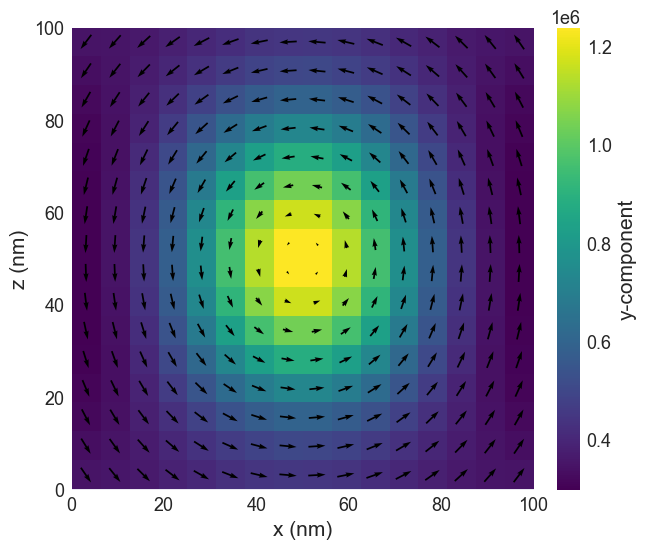

In [11]:
# Now we plot the data
system.m.sel('y').mpl()

#### Example: Manually importing data
We'll use the following directory structure given as an absolute path. First we set the directory where all the drives are located. We then define the specific directory where the data, *i.e.* the .omf files, are located. Of course, this could all be done as a single string but I'm dividing it up for clarity.

In [12]:
# Standard str format for the drives
specific_drive = 'drive-' + str(target_drive_number)  

# Define full path
manual_dir_path = os.path.join(root_project_dir, specific_project_name, specific_drive)

We need to be careful to prune any additional files produced by Ubermag's calculators. For example, the `m0.omf` file gives the initial magnetisation of the system prior to any calculations by a `Driver` object and so it should be excluded. 



In [13]:
# 'f' stands for 'file'; avoiding 'file' as a variable name to prevent confusion with the built-in 'file' function
manual_omf_files_paths = sorted([os.path.join(manual_dir_path, f) for f in os.listdir(path=manual_dir_path) if f.endswith('.omf') and f != 'm0.omf'])

# Print the paths
# manual_omf_files_paths

Printing the contents of `manual_omf_files_paths` produces a list of paths to all the .omf files we need. 

To extract our data we can use the `discretisedfield` package to read the data from the .omf files using `df.Field.from_file()`.

When we call `df.Field.from_file()` we return an object which looks like `df.Field(df.Mesh(df.Region)))`. We can use the `Mesh` object to extract key information like the total system length and the cell size. This is important because the `Field` object requires the positions to passed in units of length, and we might not always remember the parameters of a given simulation; this way we can extract the information directly from the data.

The following function ` manually_extract_data()` is a simple implementation of this process.

> The `df.Field.fromfile()` method is now deprecated in favour of `df.Field.from_file()`.

In [14]:
def manually_extract_data(extract_position: tuple | list, omf_files_paths: list, use_cellsize: bool = True) -> np.ndarray:

    # Check if the target position is 3D coordinates; format required to access `field` data
    if isinstance(extract_position, (tuple, list))  and len(extract_position) <= 3:
        pos = extract_position + (0,) * (3 - len(extract_position))
    else:
        raise ValueError("target_position must be a tuple of length 3 or less")
    
    # Empty list to hold the magnetisation values values
    m_vals = np.empty(shape=(len(omf_files_paths), 3))
    
    # Loop through all the .omf files
    for i, omf_file_path in enumerate(omf_files_paths):
        
        # Use the discretisedfield package to read the data from the .omf files
        extracted_field = df.Field.from_file(omf_file_path)
        
        # Extract the cell size from the mesh to scale the position (required for the field method)
        cell_size = extracted_field.mesh.cell if use_cellsize else np.array([1, 1, 1])
        
        # Extract the magnetization at the specified position
        m_val_at_pos = extracted_field(point=(pos * cell_size))
        
        # Store the magnetisation values
        m_vals[i] = m_val_at_pos
        
    return m_vals

What we return as `m_vals` is a `np.ndarray` where each row corresponds to a different time step and the columns correspond to the magnetisation components arranged as `[m_x, m_y, m_z]`. It's then trivial to index and/or slice the array to extract the data we need.

In [15]:
my_vals = manually_extract_data(target_position, manual_omf_files_paths)

# Print our test case which should return [ 20068.33633303,   4543.47182756, 799735.34293576].
my_vals[target_time_step]

array([ 20068.33633303,   4543.47182756, 799735.34293576])

#### Example: using `micromagneticdata.Data` method

While manual imports are great for developing intuition and understanding, there's no need to reinvent the wheel. For one, we still haven't touched on how to recover the time data associated with each time step (and other key parameters) saved in the *system_name.odt* file of each drive. Instead of developing tools to accomplish this, we can leverage Ubermag's `micromagneticdata` package to do this for us while using our newly developed intuition for how data extracting works. 

The `micromagneticdata.Data` class is a convenient way to access the data produced by Ubermag's `Driver` objects, and it's a great way to access the data in a structured way. Data is presented as `DataFrame` objects via the *Pandas* module, so we can easily manipulate the data. Additionally, Ubermag provides several custom methods (shown later) that allow us to quickly perform common operations on the data that are typically required for analysis.

The first step is to import the project directory.

In [16]:
project_data_all_drives = md.Data(name=specific_project_name,
                                  dirname=root_project_dir)

Our variable `project_data_all_drives` is a `micromagneticdata.Data` object which contains all the drives in the project directory.

Some helpful methods are available to use on `micromagneticdata.Data` objects like `project_data_all_drives` to better understand their contents. The most useful are:

>  #### `.info`
> "This property returns `pandas. DataFrame` with information about different drives found". 
> 
> We can manipulate the DataFrame like normal, such as using `.head (n=10)` or `.tail (n=10)` to display the first 10 rows. We could also use slicing to display a specific range of rows.

> #### `.path`
> "This property returns the path to the directory containing the data."

> #### `.dirname`
> "This property returns the directory name where the data is stored."

> #### `.name`
> "This property returns the name of the project."

> #### `.n`
> "This property returns the number of drives found in the directory."

In [17]:
project_data_all_drives.info[0::2]  # Display every second row

,drive_number,date,time,driver,n_threads,t,n
0,0,2024-05-29,18:29:17,MinDriver,None,NaN,NaN
2,2,2024-05-29,19:01:29,MinDriver,None,NaN,NaN
4,4,2024-05-29,19:13:20,MinDriver,None,NaN,NaN
6,6,2024-05-29,19:17:16,MinDriver,None,NaN,NaN
8,8,2024-05-29,19:17:43,MinDriver,None,NaN,NaN
10,10,2024-05-29,19:22:06,MinDriver,None,NaN,NaN
12,12,2024-05-29,19:25:25,TimeDriver,None,7.000000e-10,100.0
14,14,2024-05-29,19:25:55,TimeDriver,None,7.000000e-10,100.0
16,16,2024-05-30,13:08:12,TimeDriver,None,7.000000e-10,100.0
18,18,2024-06-03,13:04:23,TimeDriver,None,7.000000e-10,100.0


In [18]:
print(f'.path\t\t{project_data_all_drives.path}\n'
      f'.dirname\t{project_data_all_drives.dirname}\n'
      f'.name\t\t{project_data_all_drives.name}\n'
      f'.n\t\t\t{project_data_all_drives.n}'
      )

.path		/Users/cameronmceleney/PycharmProjects/Ubermag/include/breaking_test
.dirname	/Users/cameronmceleney/PycharmProjects/Ubermag/include
.name		breaking_test
.n			19


 We can now access each drive through list indexing such as `project_drive_all[n]`; n being the drive number. For now, we'll only concern ourselves with `ubermagtable.table` to view our extracted data, and the `data` method within this to display the data in a more readable format.

In [19]:
# Display the data; showing every 20th row for conciseness
project_data_all_drives[target_drive_number].table.data[0::20]

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_zeeman_static,E_exchange_exch,max_spin_ang_exch,stage_max_spin_ang_exch,run_max_spin_ang_exch,E_pump,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-1.310597e-17,239.0,213.588865,2.026202e-12,4.510250e-26,-1.310608e-17,7.141631e-23,0.098133,0.100403,0.100403,3.751704e-23,119.0,119.0,0.0,-0.000528,0.001525,0.999915,2.219433e-14,7.000000e-12
20,-1.310605e-17,4947.0,166.006837,-2.694634e-12,-4.293191e-26,-1.310614e-17,7.741492e-23,0.107352,0.107352,0.114242,1.285266e-23,2483.0,119.0,20.0,-0.000932,0.000267,0.999919,1.593821e-14,1.470000e-10
40,-1.310610e-17,9661.0,145.075343,1.579978e-12,2.979984e-26,-1.310617e-17,7.587855e-23,0.091443,0.104216,0.114242,-5.631913e-24,4850.0,118.0,40.0,-0.000134,-0.000488,0.999921,1.886679e-14,2.870000e-10
60,-1.310607e-17,14373.0,173.401521,-4.657588e-13,-1.103073e-26,-1.310618e-17,7.559583e-23,0.094143,0.094143,0.114242,3.014953e-23,7216.0,118.0,60.0,0.000657,0.000068,0.999922,2.422819e-14,4.270000e-10
80,-1.310605e-17,19079.0,172.855284,-1.278196e-12,-5.127790e-26,-1.310611e-17,7.688667e-23,0.105035,0.110867,0.114242,-1.625615e-23,9579.0,117.0,80.0,0.000362,0.001072,0.999917,4.074299e-14,5.670000e-10


#### Example: using `micromagneticdata.Drive` method

We can be slightly more direct in our extraction by using the `micromagneticdata.Drive` method. This method is useful when we know the specific drive we want to access and don't need to access the entire project directory. This gives the same output as the previous example with a slightly more readable and concise codebase.

In [20]:
# Define the specific drive we want to access
project_data_single_drive = md.Drive(name=specific_project_name, number=target_drive_number, dirname=root_project_dir)

# Display the data; showing every 20th row for conciseness
project_data_single_drive.table.data[0::20]  

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_zeeman_static,E_exchange_exch,max_spin_ang_exch,stage_max_spin_ang_exch,run_max_spin_ang_exch,E_pump,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-1.310597e-17,239.0,213.588865,2.026202e-12,4.510250e-26,-1.310608e-17,7.141631e-23,0.098133,0.100403,0.100403,3.751704e-23,119.0,119.0,0.0,-0.000528,0.001525,0.999915,2.219433e-14,7.000000e-12
20,-1.310605e-17,4947.0,166.006837,-2.694634e-12,-4.293191e-26,-1.310614e-17,7.741492e-23,0.107352,0.107352,0.114242,1.285266e-23,2483.0,119.0,20.0,-0.000932,0.000267,0.999919,1.593821e-14,1.470000e-10
40,-1.310610e-17,9661.0,145.075343,1.579978e-12,2.979984e-26,-1.310617e-17,7.587855e-23,0.091443,0.104216,0.114242,-5.631913e-24,4850.0,118.0,40.0,-0.000134,-0.000488,0.999921,1.886679e-14,2.870000e-10
60,-1.310607e-17,14373.0,173.401521,-4.657588e-13,-1.103073e-26,-1.310618e-17,7.559583e-23,0.094143,0.094143,0.114242,3.014953e-23,7216.0,118.0,60.0,0.000657,0.000068,0.999922,2.422819e-14,4.270000e-10
80,-1.310605e-17,19079.0,172.855284,-1.278196e-12,-5.127790e-26,-1.310611e-17,7.688667e-23,0.105035,0.110867,0.114242,-1.625615e-23,9579.0,117.0,80.0,0.000362,0.001072,0.999917,4.074299e-14,5.670000e-10


#### Example: using `from_file` method

This is what the latest Ubermag documentation recommends one uses. We require the path to the `.odt` file which contains the data we want to access. The avoid bloating this notebook, I've provided the path as a literal string instead of defining it as a variable with `os.path.join()`.

In [32]:
project_data_from_file_from = ut.Table.fromfile(f'{root_project_dir}/{specific_project_name}/drive-14/{specific_project_name}.odt', 
                                                x='t',
                                                rename=True)

This method innately creates a table object so we can skip to the `data` method.

In [22]:
project_data_from_file_from.data[0::20]

,E,E_calc_count,max_dm/dt,dE/dt,delta_E,E_zeeman_static,E_exchange_exch,max_spin_ang_exch,stage_max_spin_ang_exch,run_max_spin_ang_exch,E_pump,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,-1.310597e-17,239.0,213.588865,2.026202e-12,4.510250e-26,-1.310608e-17,7.141631e-23,0.098133,0.100403,0.100403,3.751704e-23,119.0,119.0,0.0,-0.000528,0.001525,0.999915,2.219433e-14,7.000000e-12
20,-1.310605e-17,4947.0,166.006837,-2.694634e-12,-4.293191e-26,-1.310614e-17,7.741492e-23,0.107352,0.107352,0.114242,1.285266e-23,2483.0,119.0,20.0,-0.000932,0.000267,0.999919,1.593821e-14,1.470000e-10
40,-1.310610e-17,9661.0,145.075343,1.579978e-12,2.979984e-26,-1.310617e-17,7.587855e-23,0.091443,0.104216,0.114242,-5.631913e-24,4850.0,118.0,40.0,-0.000134,-0.000488,0.999921,1.886679e-14,2.870000e-10
60,-1.310607e-17,14373.0,173.401521,-4.657588e-13,-1.103073e-26,-1.310618e-17,7.559583e-23,0.094143,0.094143,0.114242,3.014953e-23,7216.0,118.0,60.0,0.000657,0.000068,0.999922,2.422819e-14,4.270000e-10
80,-1.310605e-17,19079.0,172.855284,-1.278196e-12,-5.127790e-26,-1.310611e-17,7.688667e-23,0.105035,0.110867,0.114242,-1.625615e-23,9579.0,117.0,80.0,0.000362,0.001072,0.999917,4.074299e-14,5.670000e-10


 We can now access each drive through list indexing such as `project_drive_all[n]`; n being the drive number.

In [23]:
project_data_single_drive.to_xarray(name=specific_project_name)[target_time_step][target_position][target_m_component].values

array(20068.33633303)

### Process data

In [33]:
drive_table = project_data_from_file_from  # creating an alias for the sake of brevity

#### Retrieve key `Table` parameters

Each of the aforementioned import methods result in us obtaining a table. From here, we can use several useful methods and properties to extract key parameters. Note that of these properties only have a `__repr__()` method, not a call method. This means that we can't directly call them like a function, but we can invoke them with the dot operation, *e.g.* `drive_table.attributes.__repr__()` or just `drive_table.attributes`. 

> Note. If one gets a `KeyError` when trying to access the `x` and/or `dx` properties, like when taking an FFT, it's likely that they need to be defined during the loading process *e.g.* `ut.Table.fromfile(..., x='t')`.

Some important examples include:

> #### `.attributes`
> "This property returns a dictionary with attributes of the table". Mainly just indicates if a Fourier transform was performed.

In [25]:
print(f'attributes:\t\t{drive_table.attributes}')

attributes:		{'fourierspace': False}


> #### `.units`
> "This property returns a dictionary with units of the table". Returns the column names and their respective units. An empty string indicates that parameter is dimensionless.

In [26]:
print(f'units:\t\t{drive_table.units}')

units:		{'E': 'J', 'E_calc_count': '', 'max_dm/dt': 'deg/ns', 'dE/dt': 'J/s', 'delta_E': 'J', 'E_zeeman_static': 'J', 'E_exchange_exch': 'J', 'max_spin_ang_exch': 'deg', 'stage_max_spin_ang_exch': 'deg', 'run_max_spin_ang_exch': 'deg', 'E_pump': 'J', 'iteration': '', 'stage_iteration': '', 'stage': '', 'mx': '', 'my': '', 'mz': '', 'last_time_step': 's', 't': 's'}


> #### `.y`
> "This property returns a list of column names". Functionally equivalent to turning `drive_table.units.keys()` into a list.

> #### `.rfft`
> "This method performs a real Fourier transform on the table". This can useful for quick Fast Fourier Transformations. I prefer to handle this myself, but it's a useful tool to have. The `x` kwarg must be passed as a string, while the `y` kwarg can be passed as a list of strings. Both the `x` and `y` kwargs must be column names.

/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/cameronmceleney/PycharmProjects/Ubermag/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


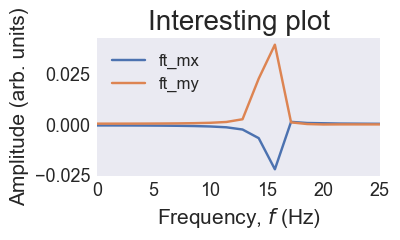

In [37]:
drive_table.rfft(x='t', y=['mx', 'my']).mpl(figsize=(4, 2.5))

# Semicolon to suppress output
plt.gcf().get_axes()[0].set(title='Interesting plot',
                            xlabel=r'Frequency, $f$ (Hz)',
                            ylabel='Amplitude (arb. units)',
                            xlim=(0, 25),
                            frame_on=True,
                            in_layout=True);
plt.gcf().get_axes()[0].grid(False);
plt.gcf().tight_layout();

> #### `.mpl`
> "This method plots scalar values as a function of ``x``.". This is a quick way to visualize the data. Be careful that the various calculated parameters are **averages** over the entire system, not the individual cells. Using `multiplier=1` can be an easy way to force the axis labels and tick markers into the correct scaling.

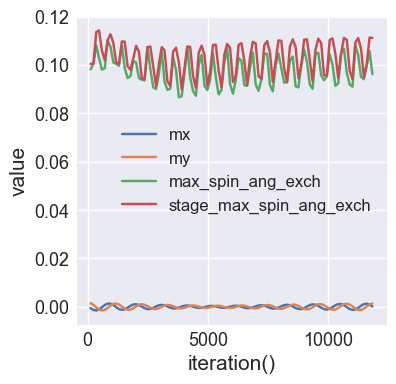

In [38]:
# Somewhat meaningless plot just to give an example
drive_table.mpl(figsize=(4, 4), 
                x='iteration', 
                y=['mx', 'my', 'max_spin_ang_exch', 'stage_max_spin_ang_exch'], 
                multiplier=1) 

### Retrieving key `data` parameters

The `data` method is the most important method to use when we want to access the data in a table. The `data` method returns a `pandas.DataFrame` object which we can manipulate like any other DataFrame object. Some useful methods include:

In [87]:
project_data_single_drive.info;

In [106]:
project_data_single_drive.to_xarray()

<xarray.DataArray 'field' (t: 100, x: 1024, y: 2, z: 2, vdims: 3)> Size: 10MB
array([[[[[ 0.00000000e+00,  0.00000000e+00,  8.00000000e+05],
          [ 0.00000000e+00,  0.00000000e+00,  8.00000000e+05]],

         [[ 0.00000000e+00,  0.00000000e+00,  8.00000000e+05],
          [ 0.00000000e+00,  0.00000000e+00,  8.00000000e+05]]],


        [[[ 6.37485253e+01,  6.77495209e+01,  7.99999995e+05],
          [ 6.37485253e+01,  6.77495209e+01,  7.99999995e+05]],

         [[ 6.37485253e+01,  6.77495209e+01,  7.99999995e+05],
          [ 6.37485253e+01,  6.77495209e+01,  7.99999995e+05]]],


        [[[ 1.23209998e+02,  1.30948438e+02,  7.99999980e+05],
          [ 1.23209998e+02,  1.30948438e+02,  7.99999980e+05]],

         [[ 1.23209998e+02,  1.30948438e+02,  7.99999980e+05],
          [ 1.23209998e+02,  1.30948438e+02,  7.99999980e+05]]],

...

        [[[-1.08346205e+03,  1.06741771e+03,  7.99998554e+05],
          [-1.08346205e+03,  1.06741771e+03,  7.99998554e+05]],

         [[-1.08346205e+03,  1.06741771e+03,  7.99998554e+05],
          [-1.08346205e+03,  1.06741771e+03,  7.99998554e+05]]],


        [[[-1.09646154e+03,  1.07641794e+03,  7.99998524e+05],
          [-1.09646154e+03,  1.07641794e+03,  7.99998524e+05]],

         [[-1.09646154e+03,  1.07641794e+03,  7.99998524e+05],
          [-1.09646154e+03,  1.07641794e+03,  7.99998524e+05]]],


        [[[-1.09470106e+03,  1.08097083e+03,  7.99998521e+05],
          [-1.09470106e+03,  1.08097083e+03,  7.99998521e+05]],

         [[-1.09470106e+03,  1.08097083e+03,  7.99998521e+05],
          [-1.09470106e+03,  1.08097083e+03,  7.99998521e+05]]]]])
Coordinates:
  * x        (x) float64 8kB 1e-09 3e-09 5e-09 ... 2.043e-06 2.045e-06 2.047e-06
  * y        (y) float64 16B 1e-09 3e-09
  * z        (z) float64 16B 1e-09 3e-09
  * vdims    (vdims) <U1 12B 'x' 'y' 'z'
  * t        (t) float64 800B 7e-12 1.4e-11 2.1e-11 ... 6.86e-10 6.93e-10 7e-10
Attributes:
    drive_number:  14
    date:          2024-05-29
    time:          19:25:55
    driver:        TimeDriver
    t:             7e-10
    n:             100
    n_threads:     None

In [87]:
project_data_all_drives.to_xarray(name='breaking_test/drive-14')[0,512,0,0].values.tolist()  # concise way to access data within a given drive: 

AttributeError: 'Data' object has no attribute 'to_xarray'

In [126]:
drive_table.units

{'E': 'J',
 'E_calc_count': '',
 'max_dm/dt': 'deg/ns',
 'dE/dt': 'J/s',
 'delta_E': 'J',
 'E_zeeman_static': 'J',
 'E_exchange_exch': 'J',
 'max_spin_ang_exch': 'deg',
 'stage_max_spin_ang_exch': 'deg',
 'run_max_spin_ang_exch': 'deg',
 'E_pump': 'J',
 'iteration': '',
 'stage_iteration': '',
 'stage': '',
 'mx': '',
 'my': '',
 'mz': '',
 'last_time_step': 's',
 't': 's'}

In [125]:
drive_table.data['t'].to_xarray()

<xarray.DataArray 't' (index: 100)> Size: 800B
array([7.00e-12, 1.40e-11, 2.10e-11, 2.80e-11, 3.50e-11, 4.20e-11,
       4.90e-11, 5.60e-11, 6.30e-11, 7.00e-11, 7.70e-11, 8.40e-11,
       9.10e-11, 9.80e-11, 1.05e-10, 1.12e-10, 1.19e-10, 1.26e-10,
       1.33e-10, 1.40e-10, 1.47e-10, 1.54e-10, 1.61e-10, 1.68e-10,
       1.75e-10, 1.82e-10, 1.89e-10, 1.96e-10, 2.03e-10, 2.10e-10,
       2.17e-10, 2.24e-10, 2.31e-10, 2.38e-10, 2.45e-10, 2.52e-10,
       2.59e-10, 2.66e-10, 2.73e-10, 2.80e-10, 2.87e-10, 2.94e-10,
       3.01e-10, 3.08e-10, 3.15e-10, 3.22e-10, 3.29e-10, 3.36e-10,
       3.43e-10, 3.50e-10, 3.57e-10, 3.64e-10, 3.71e-10, 3.78e-10,
       3.85e-10, 3.92e-10, 3.99e-10, 4.06e-10, 4.13e-10, 4.20e-10,
       4.27e-10, 4.34e-10, 4.41e-10, 4.48e-10, 4.55e-10, 4.62e-10,
       4.69e-10, 4.76e-10, 4.83e-10, 4.90e-10, 4.97e-10, 5.04e-10,
       5.11e-10, 5.18e-10, 5.25e-10, 5.32e-10, 5.39e-10, 5.46e-10,
       5.53e-10, 5.60e-10, 5.67e-10, 5.74e-10, 5.81e-10, 5.88e-10,
       5.95e-10, 6.02e-10, 6.09e-10, 6.16e-10, 6.23e-10, 6.30e-10,
       6.37e-10, 6.44e-10, 6.51e-10, 6.58e-10, 6.65e-10, 6.72e-10,
       6.79e-10, 6.86e-10, 6.93e-10, 7.00e-10])
Coordinates:
  * index    (index) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99

In [50]:
all_drives_from = ut.Table.fromfile(f'{manual_dir_path}/breaking_test.odt')

In [525]:
type(all_drives[14].to_xarray())

xarray.core.dataarray.DataArray

In [555]:
# Function to update the plot based on the selected drive
def update_plot(drive_index, pos_x, pos_y, pos_z):
    # Get the selected drive
    current_drive = drive_index
    
    # Extract magnetization at a specific position over all time steps in the selected drive
    position = (pos_x, pos_y, pos_z)  # Example: position to observe
    mx_values = [frame.array[position[0], position[1], position[2], 0] for frame in current_drive]
    my_values = [frame.array[position[0], position[1], position[2], 1] for frame in current_drive]
    mz_values = [frame.array[position[0], position[1], position[2], 2] for frame in current_drive]
    
    # Plot the magnetization components over time
    times = current_drive.table.data['t'].to_numpy()
    fig, fig_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
    fig_axs[0].plot(times, [x/8e5 for x in mx_values], label='m$_\\text{x}$ (normalized)')
    fig_axs[0].plot(times, [y/8e5 for y in my_values], label='m$_\\text{y}$ (normalized)')
    fig_axs[1].plot(times, [z/8e5 for z in mz_values], label='m$_\\text{z}$ (normalized)')
    for ax in fig_axs:
        ax.set_xlabel('Time (s)')
        # ax.set_ylabel('Magnetization (normalized)')
        ax.legend()
    fig.suptitle(f'Magnetization components at position {position}\nover time for drive {drive_index}', fontsize=20)
    fig.supxlabel(r'Time, $t$ (s)', fontsize=16)
    fig.supylabel('Magnetization (normalized)', fontsize=16)
    fig.tight_layout()
    return plt.show()
plt.show


In [557]:
widgets.interact(update_plot, drive_index=all_drives.selector(), pos_x=512, pos_y=widgets.fixed(0), pos_z=widgets.fixed(0))

interactive(children=(BoundedIntText(value=0, description='drive', max=16), IntSlider(value=512, description='…

<function __main__.update_plot(drive_index, pos_x, pos_y, pos_z)>

### Different ways to load data

After much testing, there are several ways one can load data from the .omf files produced by OOMMF/Mumax3. Which each of the following ways lead to the same outcome, knowing the differences can help in understanding the data structure and how to manipulate it.

For consistency, the objective here is to load the following variables (with the used value given in parentheses). We require:

- a particular drive (number 14 in breaking_test),

- a timestep which occurred during the execution of a (50, which corresponds to 3.5e-10 s),

- a tuple of coordinates for the cell we are interested in (512, 0, 0),

- the magnetisation component of interest (m_x == 0),

- any manipulation of the data
    - extract the values as a `np.array` or `list`

In [644]:
all_drives[14].to_xarray(name='breaking_test/drive-14')[0,512,0,0].values.tolist()  # concise way to access data within a given drive: all_drives_in_dir[drive_number][time_step][x,y,z]

[-26281.252032225362, 3230.5393322856653, 799561.6670446633]

In [ ]:
# Function to update the plot based on the selected drive
@ut.interact(drive_index=all_drives.selector(), pos_x=512, pos_y=0, pos_z=0)
def new_update_plot(drive_index, pos_x, pos_y, pos_z):
    # Get the selected drive
    current_drive = drive_index
    
    # Extract magnetization at a specific position over all time steps in the selected drive
    position = (pos_x, pos_y, pos_z)  # Example: position to observe
    mx_values = [frame.array[position[0], position[1], position[2], 0] for frame in current_drive]
    my_values = [frame.array[position[0], position[1], position[2], 1] for frame in current_drive]
    mz_values = [frame.array[position[0], position[1], position[2], 2] for frame in current_drive]
    
    # Plot the magnetization components over time
    times = current_drive.table.data['t'].to_numpy()
    fig, fig_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
    fig_axs[0].plot(times, [x/8e5 for x in mx_values], label='m$_\\text{x}$ (normalized)')
    fig_axs[0].plot(times, [y/8e5 for y in my_values], label='m$_\\text{y}$ (normalized)')
    fig_axs[1].plot(times, [z/8e5 for z in mz_values], label='m$_\\text{z}$ (normalized)')
    for ax in fig_axs:
        ax.set_xlabel('Time (s)')
        # ax.set_ylabel('Magnetization (normalized)')
        ax.legend()
    fig.suptitle(f'Magnetization components at position {position}\nover time for drive {drive_index}', fontsize=20)
    fig.supxlabel(r'Time, $t$ (s)', fontsize=16)
    fig.supylabel('Magnetization (normalized)', fontsize=16)
    fig.tight_layout()
    return plt.show()


In [517]:
# Create the widgets
drive_selector = widgets.IntSlider(min=0, max=all_drives.n-1, step=1, description='Drive Index')
position_selector = widgets.IntSlider(min=0, max=1028//2, step=1, description='X Position')

# Interactive widget to update the plot
interactive_plot = widgets.interactive(update_plot, drive_index=drive_selector, pos_x=position_selector)

# Display the widgets and the interactive plot
#display(interactive_plot)

In [518]:
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Drive Index', max=16), IntSlider(value=0, description='X…

In [165]:
current_drive = md.Drive(name='breaking_test', number=14, dirname=f'{omf_dir}')
current_drive.__repr__()

"OOMMFDrive(name='breaking_test', number=14, dirname='/Users/cameronmceleney/PycharmProjects/Ubermag/include', x='t')"

In [191]:
print(f'__repr__: {current_drive.__repr__()}')
print(f'\n\n__getattribute__: {current_drive.__getattribute__('x')}')
print(f'\n\n__getitem__: {current_drive.__getitem__(0)}')

__repr__: OOMMFDrive(name='breaking_test', number=14, dirname='/Users/cameronmceleney/PycharmProjects/Ubermag/include', x='t')


__getattribute__: t


__getitem__: Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[2.048e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[1024, 2, 2], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[2e-09, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[2e-09, 0.0, 0.0], pmax=[1e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[1e-06, 0.0, 0.0], pmax=[1.05e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeRhs`(pmin=[1.05e-06, 0.0, 0.0], pmax=[2.0479999999999997e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`fixedRhs`(pmin=[2.046e-06, 0.0, 0.0], pmax=[2.048e-06, 4e-09, 4e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']))), nvdim=3, vdims: (x, y, z), unit=A/m)


info: {'drive_number': 14, 'date': '2024-05-29',

In [240]:
print(f'info: {current_drive.info.__repr__()}')

info: {'drive_number': 14, 'date': '2024-05-29', 'time': '19:25:55', 'driver': 'TimeDriver', 't': 7e-10, 'n': 100, 'n_threads': None}


In [243]:
# current_drive.table.data
print(f'attributes: {current_drive.table.attributes.__repr__()}'
      f'\n\nunits: {current_drive.table.units.__repr__()}'
      f'\n\ndx: {current_drive.table.dx.__repr__()}'
      f'\n\nx: {current_drive.table.x.__repr__()}'
      f'\n\ny: {current_drive.table.y.__repr__()}')

attributes: {'fourierspace': False}

units: {'E': 'J', 'E_calc_count': '', 'max_dm/dt': 'deg/ns', 'dE/dt': 'J/s', 'delta_E': 'J', 'E_zeeman_static': 'J', 'E_exchange_exch': 'J', 'max_spin_ang_exch': 'deg', 'stage_max_spin_ang_exch': 'deg', 'run_max_spin_ang_exch': 'deg', 'E_pump': 'J', 'iteration': '', 'stage_iteration': '', 'stage': '', 'mx': '', 'my': '', 'mz': '', 'last_time_step': 's', 't': 's'}

dx: 7e-12

x: 't'

y: ['E', 'E_calc_count', 'max_dm/dt', 'dE/dt', 'delta_E', 'E_zeeman_static', 'E_exchange_exch', 'max_spin_ang_exch', 'stage_max_spin_ang_exch', 'run_max_spin_ang_exch', 'E_pump', 'iteration', 'stage_iteration', 'stage', 'mx', 'my', 'mz', 'last_time_step']


In [572]:
drive_man = current_drive[50].to_xarray(name='my test', unit='A/m')

In [573]:
pos_x = 512
pos_y = 0
pos_z = 0
pos_vec = (pos_x, pos_y, pos_z)
# Some ways of extracting information directly
print(f'{drive_man[pos_vec].name}'
      f'\n{drive_man[pos_vec].data}'  # or t1[512,0,0].data or drive_man[pos_vec].__array__()
      f'\n{drive_man[pos_vec].indexes}'
      f'\n{drive_man[pos_vec].attrs}'
)
# drive_man[pos_vec].__getstate__()[1]  # to see full info
drive_man[pos_vec]  # drive_man[pos_vec].__repr__()

my test
[ 20068.33633303   4543.47182756 799735.34293576]
Indexes:
    vdims    Index(['x', 'y', 'z'], dtype='object', name='vdims')
{'units': 'A/m', 'cell': array([2.e-09, 2.e-09, 2.e-09]), 'pmin': array([0., 0., 0.]), 'pmax': array([2.048e-06, 4.000e-09, 4.000e-09]), 'nvdim': 3, 'tolerance_factor': 1e-12}


<xarray.DataArray 'my test' (vdims: 3)> Size: 24B
array([ 20068.33633303,   4543.47182756, 799735.34293576])
Coordinates:
    x        float64 8B 1.025e-06
    y        float64 8B 1e-09
    z        float64 8B 1e-09
  * vdims    (vdims) <U1 12B 'x' 'y' 'z'
Attributes:
    units:             A/m
    cell:              [2.e-09 2.e-09 2.e-09]
    pmin:              [0. 0. 0.]
    pmax:              [2.048e-06 4.000e-09 4.000e-09]
    nvdim:             3
    tolerance_factor:  1e-12

In [382]:
drive_man[:,0,0].__array__()[:, 0]

array([  0.        ,  63.74852525, 123.20999765, ..., 676.58711485,
       687.95845108, 697.12737191])

In [386]:
drive_man[:,0,0].__array__()[:, 0]
drive_man.__array__()[:,0,0,0]

array([  0.        ,  63.74852525, 123.20999765, ..., 676.58711485,
       687.95845108, 697.12737191])

In [119]:
filtered_df = all_drives.info[all_drives.info['driver'] == 'TimeDriver']
filtered_df = filtered_df[filtered_df['n'] == 100]

In [128]:
filtered_df

,drive_number,date,time,driver,n_threads,t,n
11,11,2024-05-29,19:22:27,TimeDriver,None,7.000000e-10,100.0
12,12,2024-05-29,19:25:25,TimeDriver,None,7.000000e-10,100.0
13,13,2024-05-29,19:25:35,TimeDriver,None,7.000000e-10,100.0
14,14,2024-05-29,19:25:55,TimeDriver,None,7.000000e-10,100.0
16,16,2024-05-30,13:08:12,TimeDriver,None,7.000000e-10,100.0


In [136]:
all_drives.info[['drive_number', 'date', 'time', 'driver', 'n']]

,drive_number,date,time,driver,n
0,0,2024-05-29,18:29:17,MinDriver,NaN
1,1,2024-05-29,18:29:19,TimeDriver,4000.0
2,2,2024-05-29,19:01:29,MinDriver,NaN
3,3,2024-05-29,19:01:31,TimeDriver,4000.0
4,4,2024-05-29,19:13:20,MinDriver,NaN
5,5,2024-05-29,19:13:21,TimeDriver,4000.0
6,6,2024-05-29,19:17:16,MinDriver,NaN
7,7,2024-05-29,19:17:17,TimeDriver,4000.0
8,8,2024-05-29,19:17:43,MinDriver,NaN
9,9,2024-05-29,19:17:44,TimeDriver,4000.0


In [149]:
[frame.array[512, 0, 0, 0] for frame in current_drive]

[-26281.252032225362,
 -20249.37498535215,
 -4977.855152618733,
 11659.023044268957,
 22079.484116542746,
 21922.33379198861,
 11662.324800970973,
 -3473.4273644500367,
 -16538.275994599408,
 -21427.794059835287,
 -16374.854716490448,
 -3796.142207278556,
 10080.670163845894,
 19006.489860349815,
 18802.84885251111,
 9916.469255063996,
 -3446.6485142923807,
 -14937.150700173264,
 -19235.069417614377,
 -14511.870449792857,
 -2992.2713704887974,
 9722.038057543694,
 17835.694744455403,
 17410.535282433604,
 8911.793950690884,
 -3838.889624015901,
 -14646.89117733564,
 -18627.370742050738,
 -13785.800214359051,
 -2501.780936420269,
 10009.271086041901,
 17863.102532292265,
 17344.84523582924,
 8729.39083129063,
 -4111.815914896957,
 -15043.094697484594,
 -19135.7487851692,
 -14204.591226933831,
 -2686.259550517983,
 10321.860525203718,
 18581.94441433592,
 18365.975439870752,
 9534.708732602256,
 -3817.5080361167243,
 -15590.521199702163,
 -20319.803804343646,
 -15652.713354478085,
 -3741

In [45]:
print(len(sel_vals))

100


In [137]:
# Initialize lists to store magnetization components
times = []
mx_values = []
my_values = []
mz_values = []

omf_dir2 = '/Users/cameronmceleney/PycharmProjects/Ubermag/include/breaking_test/drive-14'

# List all .omf files in the directory
omf_files2 = sorted([f for f in os.listdir(omf_dir2) if f.endswith('.omf') and f != 'm0.omf'])

In [138]:
# Read each .omf file and extract the magnetization at the specified position
for omf_file in omf_files2:
    # Read the field from the .omf file
    field = df.Field.from_file(os.path.join(omf_dir2, omf_file))
    
    # Extract the magnetization components at the specified position
    m_at_pos = field(position)
    mx_values.append(m_at_pos[0])
    my_values.append(m_at_pos[1])
    mz_values.append(m_at_pos[2])
    
    # Extract the time from the filename (assuming filenames have time information)
    # Example: "filename_t=0.omf" -> time = 0
    #time = float(omf_file.split('t=')[1].split('.omf')[0])
    #times.append(time)

In [139]:
print(mx_values)

[-26281.252032225362, -20249.37498535215, -4977.855152618733, 11659.023044268957, 22079.484116542746, 21922.33379198861, 11662.324800970973, -3473.4273644500367, -16538.275994599408, -21427.794059835287, -16374.854716490448, -3796.142207278556, 10080.670163845894, 19006.489860349815, 18802.84885251111, 9916.469255063996, -3446.6485142923807, -14937.150700173264, -19235.069417614377, -14511.870449792857, -2992.2713704887974, 9722.038057543694, 17835.694744455403, 17410.535282433604, 8911.793950690884, -3838.889624015901, -14646.89117733564, -18627.370742050738, -13785.800214359051, -2501.780936420269, 10009.271086041901, 17863.102532292265, 17344.84523582924, 8729.39083129063, -4111.815914896957, -15043.094697484594, -19135.7487851692, -14204.591226933831, -2686.259550517983, 10321.860525203718, 18581.94441433592, 18365.975439870752, 9534.708732602256, -3817.5080361167243, -15590.521199702163, -20319.803804343646, -15652.713354478085, -3741.5693300158814, 10164.36179722186, 19482.146872

In [ ]:
# Plot the magnetization components over time
plt.figure(figsize=(8, 6))
plt.plot(times, mx_values, label='m$_\\text{x}$ (normalized)')
plt.plot(times, my_values, label='m$_\\text{y}$ (normalized)')
#plt.plot(times, mz_values, label='m$_\\text{z}$ (normalized)')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization (normalized)')
plt.title('Magnetization components at position {} over time'.format(position))
plt.legend()
plt.grid()
plt.show()